In [1]:
import os
import yaml
import simpy
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['hatch.linewidth'] = 0.2  # previous pdf hatch linewidth
from yaml import Loader

from ORBIT.core.library import initialize_library
initialize_library(os.path.join(os.getcwd(), "east_coast_analysis", "library"))
from CORAL import SharedLibrary, GlobalManager, Pipeline

projects = os.path.join(os.getcwd(), "east_coast_analysis", "updated_pipeline.csv")
base = os.path.join(os.getcwd(), "east_coast_analysis", "base.yaml")
pipeline = Pipeline(projects, base)

# weather = pd.read_csv("east_coast_analysis/library/weather/vineyard_wind_weather_1983_2017_orbit.csv", parse_dates=['datetime']).set_index('datetime')

ORBIT library intialized at '/Users/jnunemak/repos/external/CORAL/east_coast_analysis/library'


In [2]:
allocations = {
    "wtiv": ('example_wtiv', 2),
    "feeder": ('example_feeder', 3),
    "port": [('northeast', 2), ('central', 1), ('south', 1)]
}

library_path = os.path.join(os.getcwd(), "east_coast_analysis", "library")

env = simpy.Environment()
library = SharedLibrary(env, allocations, path=library_path)
library.setup()


In [3]:
manager = GlobalManager(pipeline.configs, allocations, library_path=library_path)#, weather=weather)
manager.run()

In [4]:
df = pd.DataFrame(manager.logs).iloc[::-1]
df = df.reset_index(drop=True).reset_index()

port_map = pipeline.projects[["name", "port_region"]].set_index("name").to_dict()['port_region']
df['port'] = [port_map[name] for name in df['name']]

# df

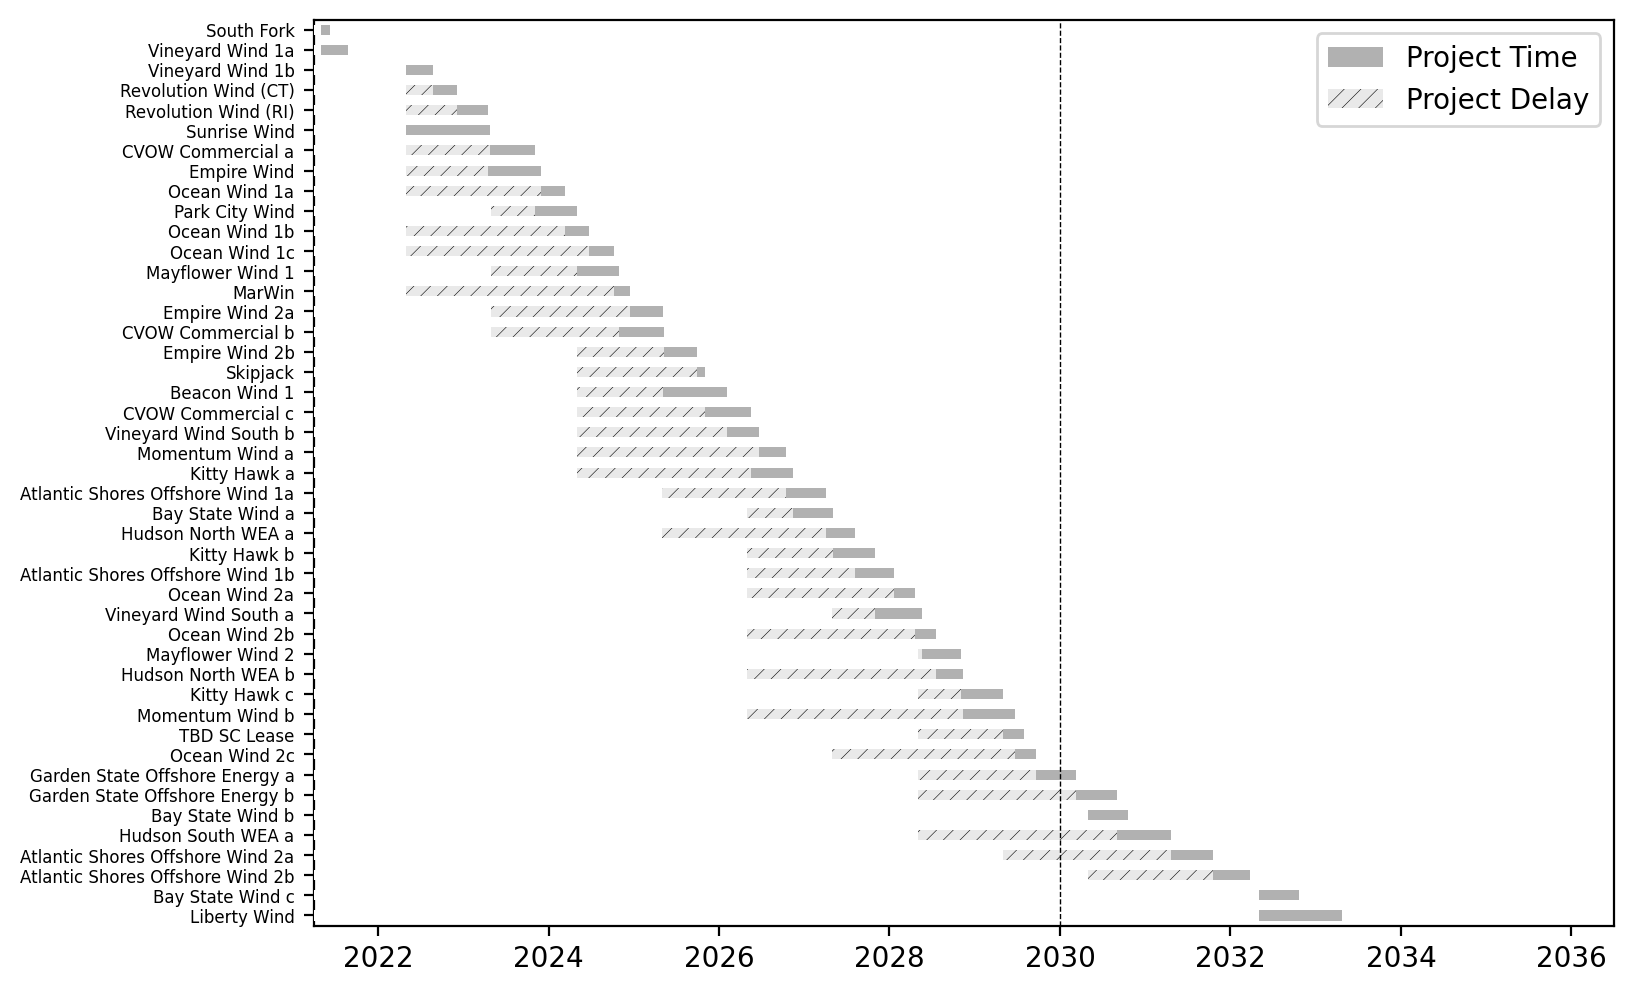

In [5]:
fig = plt.figure(figsize=(10, 6), dpi=200)
ax = fig.add_subplot(111)

color_map = {
    "northeast": "tab:green",
    "central": "tab:red",
    "south": "tab:blue"
}

df["Date Finished"].plot(kind="barh", ax=ax, zorder=4, label="Project Time", color="#b1b1b1")
df["Date Started"].plot(kind="barh", color="#e9e9e9", ax=ax, zorder=4, label="Project Delay", hatch="////", linewidth=0.5)
df["Date Initialized"].plot(kind='barh', ax=ax, zorder=4, label="__nolabel__", color='w')

# df.plot(kind="scatter", x="request-wtiv-date", y="index", color='tab:orange', ax=ax, zorder=5, label="WTIV", marker="x")

# groups = df.groupby("port")
# for name, group in groups:
#     group.plot(kind="scatter", x="request-port-date", y="index", ax=ax, marker="x", c=color_map[name], zorder=5, label=f"{name} ports".capitalize())

ax.axvline(dt.date(2030, 1, 1), lw=0.5, ls="--", color="k", zorder=6)
    
# Plot formatting
ax.set_xlabel("")
ax.set_ylabel("")
_ = ax.set_yticklabels(df['name'])
plt.yticks(fontsize=6)
ax.legend()
ax.set_xlim(manager._start - dt.timedelta(days=30), dt.date(2036, 6, 1) + dt.timedelta(days=30))#df["Date Finished"].max() + dt.timedelta(days=30))

# installed_capacity = get_installed_capacity_by(df, 2030)
# ax.text(x=dt.date(2032, 8, 1), y=27, s=f"Capacity Installed by 2030:\n     {installed_capacity:,.0f} MW", fontsize=8)

fig.subplots_adjust(left=0.25)